In [1]:
from astropy.table import Table, hstack, vstack, unique
from astropy import units as u
import astropy.coordinates as coord
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import pickle
import matplotlib
from pm_func_edr3 import *
from copy import copy

In [20]:
dir = 'D:/pzivi/Research/Gurtina_Project/'

num = "2"

datasource = "allstar_Model" + num
model = Table.read(dir + "Data/"+datasource+".fits")

print("Number of Model " + num + " stars is " + str(len(model)))

plotc = "tomato"  #tomato, royalblue, violet
#relc = "darkred"
#rvc = "forestgreen"

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

print(model.info())

Number of Model 2 stars is 233384
<Table length=233384>
 name  dtype 
----- -------
  Age float64
  X_0 float64
  Y_0 float64
  Z_0 float64
 Vx_0 float64
 Vy_0 float64
 Vz_0 float64
  X_G float64
  Y_G float64
  Z_G float64
 Vx_G float64
 Vy_G float64
 Vz_G float64
   RA float64
  DEC float64
 Dist float64
 PMRA float64
PMDEC float64
   RV float64
None


198969
198969


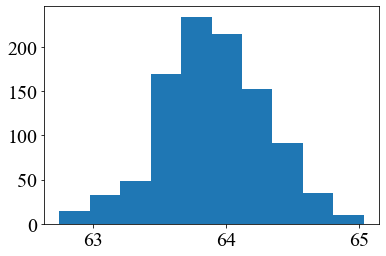

In [33]:
print(len(model))

model = model[(model['Dist'] < 80.0) & (model['Dist'] > 40.0) & \
              (model['RA'] < 25.0) & (model['RA'] > 0.0) & \
              (model['DEC'] < -60.0) & (model['DEC'] > -80.0)]

print(len(model))

model = model[:1000]

plt.clf()
plt.hist(model['Dist'])
plt.show()

In [34]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax = -5.0, 5.0, -6.0, 5.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

pmramin, pmramax, pmdecmin, pmdecmax, rvmin, rvmax = -1.5, 3.0, -3.5, 1.5, 50.0, 250.0

displayvals.append(pmramin)
displayvals.append(pmramax)
displayvals.append(pmdecmin)
displayvals.append(pmdecmax)
displayvals.append(rvmin)
displayvals.append(rvmax)


## Set bin widths

xwidth, ywidth = 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)

In [35]:
#### Because this is sim data, it hasn't gone through other cuts, so I need to calculate x/y values

ra0 = np.deg2rad(13.038)
dec0 = np.deg2rad(-73.094)
dist0 = 60.6

center = np.asarray([ra0, dec0])

# tempx, tempy = wcs2gaiaxy(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), center)

# ## Add the cartesian coordinates as new columns to the catalog

# tempx.shape = (len(tempx),)
# tempy.shape = (len(tempy),)

# model.add_column(tempx, name="x")
# model.add_column(tempy, name="y")

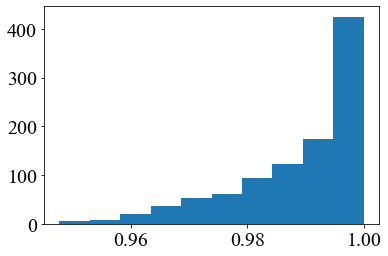

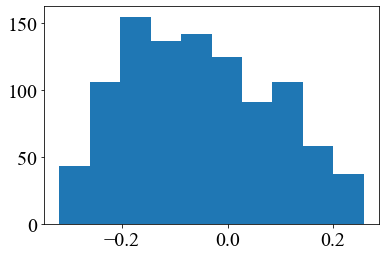

In [36]:
rho, phi = wcs2ang(ra0, dec0, np.deg2rad(model['RA']), np.deg2rad(model['DEC']))

newxyz = ang2xyz(rho, phi, model['Dist'], dist0, theta=0, incl=0)


mat_pmw = np.reshape(-1.*model['PMRA'], (len(model),1))
mat_pmn = np.reshape(model['PMDEC'], (len(model),1))
mat_v1 = np.reshape(model['RV'], (len(model),1))



cosG, sinG = calc_gamma(ra0, dec0, np.deg2rad(model['RA']), np.deg2rad(model['DEC']), rho)

plt.clf()
plt.hist(cosG)
plt.show()

plt.clf()
plt.hist(sinG)
plt.show()

matrix = np.zeros((len(model), 2, 2))
matrix[:,0,0] = -1.*sinG
matrix[:,0,1] = -1.*cosG
matrix[:,1,0] = cosG
matrix[:,1,1] = sinG

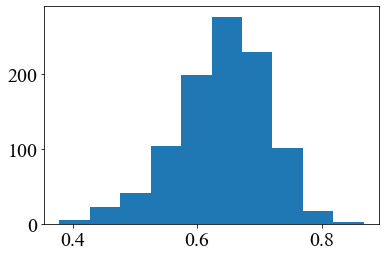

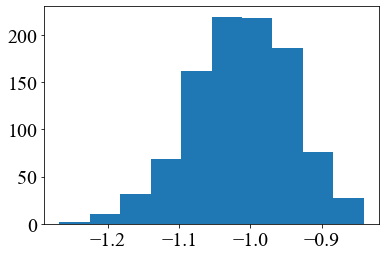

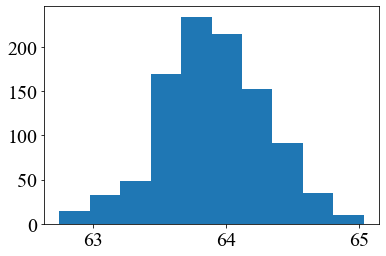

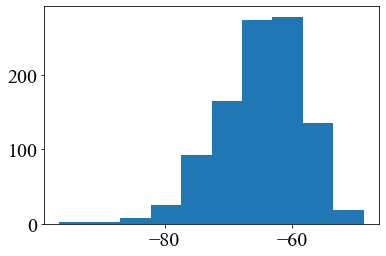

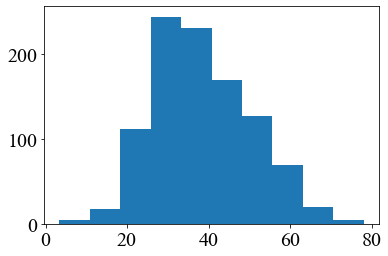

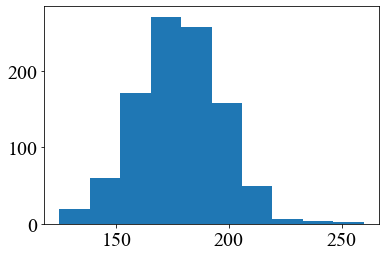

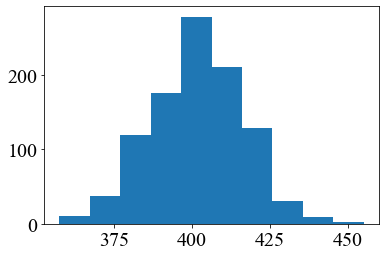

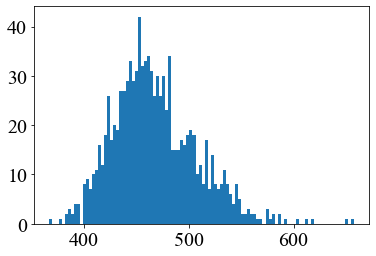

In [38]:
pm = np.zeros((len(model), 2, 1))
pm[:,0] = mat_pmw
pm[:,1] = mat_pmn

temp = np.zeros((len(model), 2, 1))

# print(matrix[0])
# print(np.linalg.det(matrix[0]))
# print(np.linalg.inv(matrix[0]))
# print(np.dot(matrix[0], np.linalg.inv(matrix[0])))
# print(pm[0])
# print(np.dot(np.linalg.inv(matrix[0]), pm[0]))

for i in range(len(matrix)):
    temp[i] = model[i]['Dist']*np.dot(np.linalg.inv(matrix[i]), pm[i])
#     print(temp[i])

plt.clf()
plt.hist(model['PMRA'])
plt.show()

plt.clf()
plt.hist(model['PMDEC'])
plt.show()
    
plt.clf()
plt.hist(model['Dist'])
plt.show()
    
plt.clf()
plt.hist(np.reshape(temp[:,0],(len(temp),)))
plt.show()

plt.clf()
plt.hist(np.reshape(temp[:,1],(len(temp),)))
plt.show()

plt.clf()
plt.hist(np.sqrt(model['Vx_G']**2 + model['Vy_G']**2 + model['Vz_G']**2))
plt.show()

plt.clf()
plt.hist(np.sqrt((4.74*model['Dist']*model['PMRA'])**2 + (4.74*model['Dist']*model['PMDEC'])**2 + model['RV']**2))
plt.show()

plt.clf()
plt.hist(np.sqrt(model['RV']**2 + (4.74*np.reshape(temp[:,0],(len(temp),)))**2 + \
                 (4.74*np.reshape(temp[:,0],(len(temp),)))**2), bins=100)
plt.show()

In [ ]:
new_vxyz = np.zeros((len(model), 3))
new_vxyz[:,0], new_vxyz[:,1], new_vxyz[:,2] = wcs2xyz_vec(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), rho, \
                                                          phi, model['Dist'], ra0, dec0, mat_pmw, mat_pmn, mat_v1)

try:
    model.add_column(newxyz[:,0], name='X_S')
    model.add_column(newxyz[:,1], name='Y_S')
    model.add_column(newxyz[:,2], name='Z_S')
    model.add_column(new_vxyz[:,0], name='VX_S')
    model.add_column(new_vxyz[:,1], name='VY_S')
    model.add_column(new_vxyz[:,2], name='VZ_S')
    
except ValueError:
    print("You already added these columns.")

<Figure size 432x288 with 0 Axes>

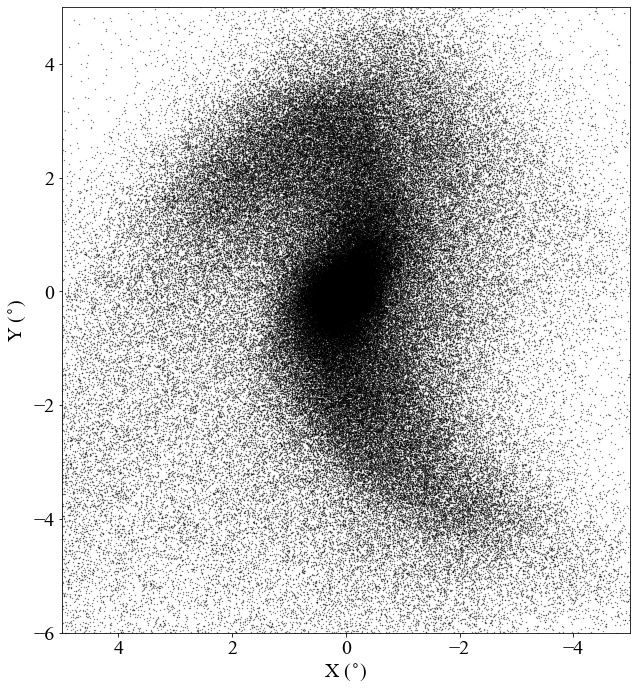

In [6]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(model['X_S'], model['Y_S'], s=8, lw=0, marker=".", color='black', alpha=0.5)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
ax.invert_xaxis()
plt.tight_layout()
plt.show()

In [11]:
tempx, tempy = wcs2gaiaxy(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), center)

gaia_vxy = np.zeros((len(model),2))
gaia_vxy[:,0], gaia_vxy[:,1] = vecwcs2gaiaxy(model['PMRA'], model['PMDEC'], np.deg2rad(model['RA']), \
                                     np.deg2rad(model['DEC']), center)

gaia_model = Table([tempx, tempy, gaia_vxy[:,0], gaia_vxy[:,1]], names=('X_Gaia', 'Y_Gaia', 'VX_Gaia', 'VY_Gaia'))

<Figure size 432x288 with 0 Axes>

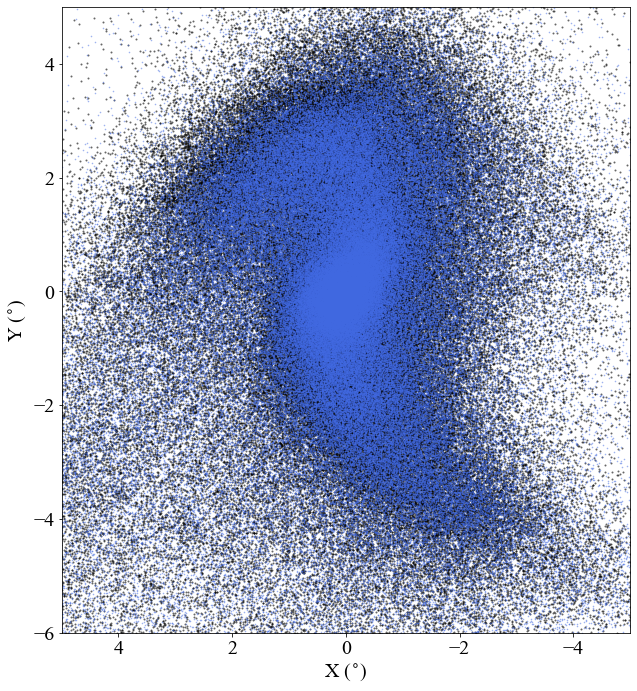

In [10]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(model['X_S'], model['Y_S'], s=16, lw=0, marker=".", color='black', alpha=0.6)
ax.scatter(-1*tempx, tempy, s=10, lw=0, marker=".", color='royalblue', alpha=0.5)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
ax.invert_xaxis()
plt.tight_layout()
plt.show()

In [16]:
model_pmbins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'X_S', 'Y_S', 'VX_S', 'VY_S')
gaia_pmbins = vec_grid(gaia_model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'X_Gaia', 'Y_Gaia', 'VX_Gaia', 'VY_Gaia')

pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3

<Figure size 432x288 with 0 Axes>

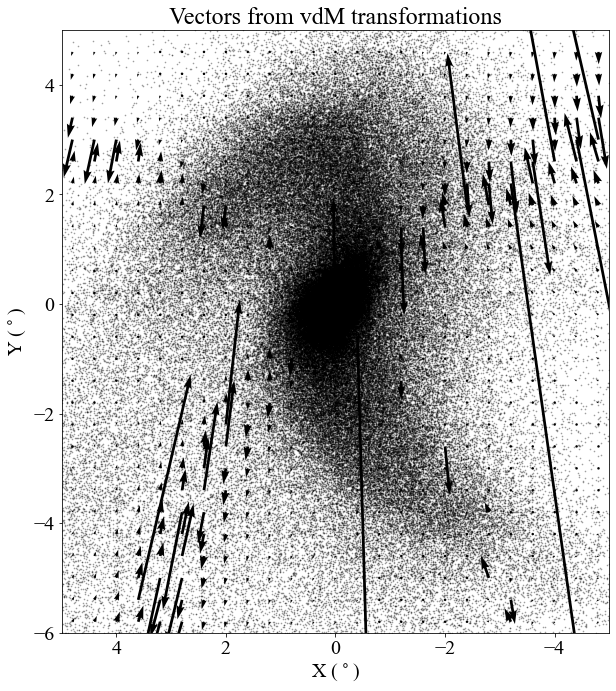

In [33]:
#### 
# Plot averaged residual vectors for young stars
####

visscale = 0.1

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['X_S'], model['Y_S'], s=2, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(model_pmbins[:,pmbinx], model_pmbins[:,pmbiny], \
                (visscale*model_pmbins[:,pmbinpmx]), \
                (visscale*model_pmbins[:,pmbinpmy]), lw=2, \
                units="xy", color="black", \
                width=0.05)


ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Vectors from vdM transformations")
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

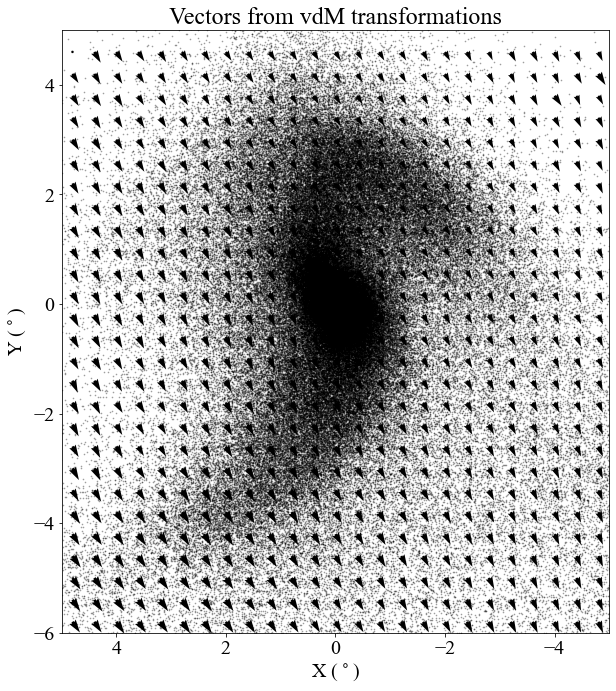

In [35]:
#### 
# Plot averaged residual vectors for young stars
####

visscale = 0.1

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(gaia_model['X_Gaia'], gaia_model['Y_Gaia'], s=2, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(gaia_pmbins[:,pmbinx], gaia_pmbins[:,pmbiny], \
                (visscale*gaia_pmbins[:,pmbinpmx]), \
                (visscale*gaia_pmbins[:,pmbinpmy]), lw=2, \
                units="xy", color="black", \
                width=0.05)


ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Vectors from vdM transformations")
plt.tight_layout()
plt.show()

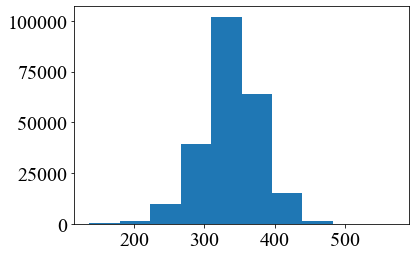

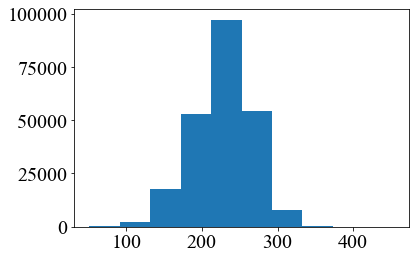

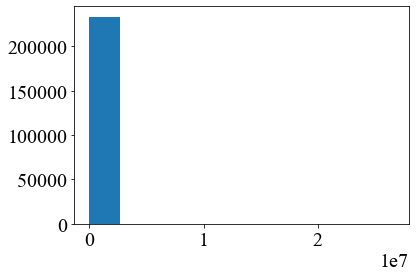

In [36]:
plt.clf()
plt.hist(np.sqrt(model['Vx_0']**2 + model['Vy_0']**2  + model['Vz_0']**2))
plt.show()

plt.clf()
plt.hist(np.sqrt(model['Vx_G']**2 + model['Vy_G']**2  + model['Vz_G']**2))
plt.show()

plt.clf()
plt.hist(np.sqrt(model['VX_S']**2 + model['VY_S']**2  + model['VZ_S']**2))
plt.show()